## Examen Aprendizaje Profundo

#### Alumno: Lucas Rivela
#### Cohorte: 5
#### Profesores: Ezequiel Esposito y Marcos Maillot

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

#### Punto 1

Para el modelo propuesto lo que voy a hacer es tener una loss function que exprese el error cuadrático medio (MSE) y luego voy a calcular la derivada de esta salida respecto de cada parámetro de la ecuación, utilizando la regla de la cadena

##### Modelo

$\hat{y} = x^3w_{1} + x^2w_{2} + xw_{1} + b$

##### Loss function

$L = (y_{i} - \hat{y_{i}})^2$

$\frac{\partial L}{\partial \hat{y}} = -2 . (y - \hat{y})$

##### Derivada respecto de $w_{1}$

$\frac{\partial L}{\partial {w_{1}}} = \frac{\partial L}{\partial \hat{y}} . \frac{\partial \hat{y}}{\partial w_{1}} = -2 . (y - \hat{y}) . (x^3 + x) $

##### Derivada respecto de $w_{2}$

$\frac{\partial L}{\partial {w_{2}}} = \frac{\partial L}{\partial \hat{y}} . \frac{\partial \hat{y}}{\partial w_{2}} = -2 . (y - \hat{y}) . (x^2) $

##### Derivada respecto de $b$

$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial \hat{y}} . \frac{\partial \hat{y}}{\partial b} = -2 . (y - \hat{y}) $

In [56]:
# Hiperparametros
n_epochs = 1000
alfa = 0.001
batches = 10
epsilon = 0.1

In [57]:
# Inicializo pesos de forma aleatoria
w1 = random.uniform(0, 1)
w2 = random.uniform(0, 1)
b = random.uniform(0, 1)
print(w1, w2, b)

0.514398494861493 0.9668374007716195 0.43577147061524024


In [16]:
# Cargo el dataset
dataset = np.genfromtxt('dataset_1.csv', delimiter=',')
print("Shape ", dataset.shape)
print("NaNs ", np.isnan(np.sum(dataset)))

Shape  (10000, 2)
NaNs  False


In [9]:
def calculate_y_hat(X, w1, w2, b):
    """
    Función que hace el forward del modelo

    Parameters:
        X: Input batch del modelo para predecir el resultado
        w1: Peso para w1
        w2: Peso para w2
        b: Peso para b
    Returns:
        y_hat: (np.array) Predicciones del batch
    """
    y_hat = w1*(X**3) + w2*(X**2) + w1*(X) + [b] * len(X)
    return y_hat

In [10]:
def calculate_loss_w1(err, X_batch):
    """
    Función que calcula la derivada de la loss function respecto del peso w1

    Parameters:
        err: Error del batch
        X_batch: Input batch del modelo

    Returns:
        loss_w1: Derivada de la loss function respecto de w1 para el batch
    """
    loss = -2 * err * ( (X_batch**3) + (X_batch) )
    return np.sum(loss) / len(X_batch)

In [11]:
def calculate_loss_w2(err, X_batch):
    """
    Función que calcula la derivada de la loss function respecto del peso w2

    Parameters:
        err: Error del batch
        X_batch: Input batch del modelo

    Returns:
        loss_w2: Derivada de la loss function respecto de w2 para el batch
    """
    loss = -2 * err * (X_batch**2)
    return np.sum(loss) / len(X_batch)

In [12]:
def calculate_loss_b(err, X_batch):
    """
    Función que calcula la derivada de la loss function respecto del peso b

    Parameters:
        err: Error del batch
        X_batch: Input batch del modelo

    Returns:
        loss_b: Derivada de la loss function respecto de b para el batch
    """
    loss = -2 * err
    return np.sum(loss) / len(X_batch)

In [30]:
def create_mini_batches(dataset, batch_size):
    """
    Función que genera batches a partir de un dataset y un tamaño de batch

    Parameters:
        dataset: Dataset
        batch_size: tamaño del batch

    Returns:
        mini_batches: Lista de batches
    """
    mini_batches = []
    for i in range(0, dataset.shape[0], batch_size):
        mini_batch = np.array(dataset[i: i + batch_size,])
        mini_batches.append(mini_batch)
    
    return mini_batches

In [58]:
#batch_list = create_mini_batches(dataset[:8000,], batches)
batch_list = create_mini_batches(dataset, batches)
print("Training", len(batch_list))
#validation_batch = create_mini_batches(dataset[8001:,], batches)
#print("Validation", len(validation_batch))

Training 1000


In [59]:
ecm = []
val_ecm = []
for e in range(n_epochs):
    change_w1 = 0
    change_w2 = 0
    change_b = 0
    mse_batch = 0
    mse_val = 0

    for batch in batch_list:
        y_hat = calculate_y_hat(batch[:,0], w1, w2, b)
        err = (batch[:,1] - y_hat)

        loss_w1 = calculate_loss_w1(err, batch[:,0])
        loss_w2 = calculate_loss_w2(err, batch[:,0])
        loss_b = calculate_loss_b(err, batch[:,0])

        new_change_w1 = ( alfa * loss_w1 + epsilon * change_w1 )
        new_change_w2 = ( alfa * loss_w2 + epsilon * change_w2 )
        new_change_b = ( alfa * loss_b + epsilon * change_b )

        w1 = w1 - new_change_w1
        w2 = w2 - new_change_w2
        b = b - new_change_b

        change_w1 = new_change_w1
        change_w2 = new_change_w2
        change_b = new_change_b

        mse_batch += np.sum(err ** 2) / batch.shape[0]
    ecm.append(mse_batch)

    #for batch in validation_batch:
    #    y_hat = calculate_y_hat(batch[:,0], w1, w2, b)
    #    err = (batch[:,1] - y_hat)
    #    mse_val += np.sum(err ** 2) / batch.shape[0]
    #val_ecm.append(mse_val)

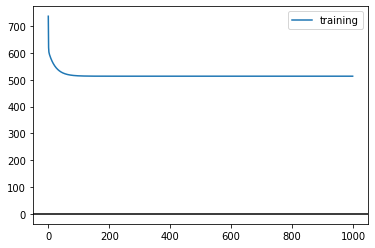

In [61]:
plt.plot(range(n_epochs), ecm, label='training')
plt.axhline(y=0, color='k')
plt.legend()

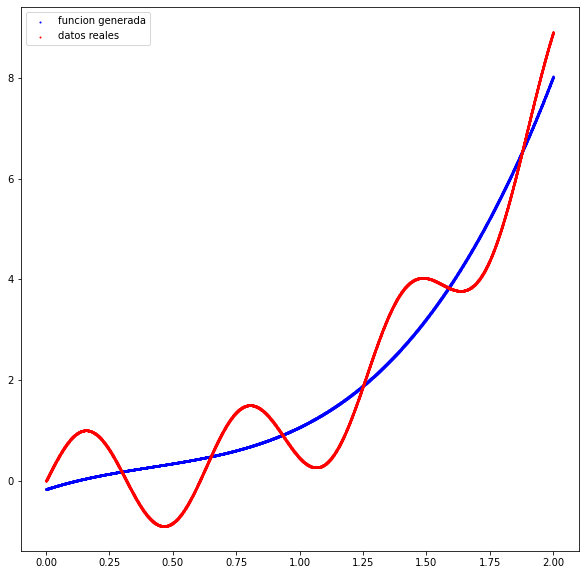

In [306]:
y_hat = calculate_y_hat(dataset[:,0], w1, w2, b)
plt.figure(figsize=(10,10))
plt.scatter(dataset[:,0], y_hat, label='funcion generada', c='blue', s=1)
plt.scatter(dataset[:,0], dataset[:,1], label='datos reales', c='red', s=1)
plt.legend()

De los gráficos anteriores se puede ver que el modelo está haciendo underfitting. Esto es así porque el MSE queda estancado y no logra seguir descendiendo. Además cuando vemos el scatterplot del $y$ real vs el $\hat{y}$; la función no tiene la flexibilidad necesaria para adaptarse a la curva.

#### Punto 2

In [14]:
class MyDataset(Dataset):

    def __init__(self, X, y):
      super().__init__()
      self.X = X
      self.y = y

    def __len__(self):
      return self.X.shape[0]

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

In [17]:
train = MyDataset(np.expand_dims(dataset[:,0], axis=0).T, np.expand_dims(dataset[:,1], axis=0).T)
#validation = MyDataset(np.expand_dims(dataset[8000:,0], axis=0).T, np.expand_dims(dataset[8000:,1], axis=0).T)

In [18]:
print("Train", len(train))
#print("Validation", len(validation))

Train 10000


In [19]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=False)
#valid_dataloader = DataLoader(validation, batch_size=64, shuffle=False)

In [20]:
class NNet(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=20, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.linear_4 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_4 = torch.nn.ReLU()
        self.linear_5 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_5 = torch.nn.ReLU()
        self.linear_6 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_6 = torch.nn.ReLU()
        self.linear_7 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_7 = torch.nn.ReLU()
        self.linear_8 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_8 = torch.nn.ReLU()
        self.linear_9 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_9 = torch.nn.ReLU()
        self.linear_10 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_10 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=20, out_features=1, bias=True)

    def forward(self, x): # x.shape -> 64x1
        x = self.linear_1(x) # 64x20
        x = self.relu_1(x) # 64x20
        x = self.linear_2(x) # 64x20
        x = self.relu_2(x) # 64x20
        x = self.linear_3(x) # 64x20
        x = self.relu_3(x) # 64x20
        x = self.linear_4(x) # 64x20
        x = self.relu_4(x) # 64x20
        x = self.linear_5(x) # 64x20
        x = self.relu_5(x) # 64x20
        x = self.linear_6(x) # 64x20
        x = self.relu_6(x) # 64x20
        x = self.linear_7(x) # 64x20
        x = self.relu_7(x) # 64x20
        x = self.linear_8(x) # 64x20
        x = self.relu_8(x) # 64x20
        x = self.linear_9(x) # 64x20
        x = self.relu_9(x) # 64x20
        x = self.linear_10(x) # 64x20
        x = self.relu_10(x) # 64x20
        x = self.output(x) # 64x1
        return x

In [302]:
nnet = NNet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()

In [21]:
device = ""
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

In [22]:
RANGE=100

In [303]:
nnet.to(device)

loss_list = []
validation_loss_list = []
for epoch in range(RANGE):
    running_loss = 0
    running_y_score = []
    running_validation_loss = 0
    running_validation_y_score = []
    y_label = []
    
    #### TRAINING ####
    for i, data in enumerate(train_dataloader):
        X_batch, y_batch = data #  Datos del batch
        X_batch = X_batch.to(device).float()
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = nnet(X_batch)

        # backprop
        loss = loss_function(y_batch_score, Y_batch)  # Calcula el loss
        loss.backward()  # Hacer los gradientes del loss

        # actualizacion de parametros
        optimizer.step()

        # metrics
        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())

    # Metrics
    loss_list.append(running_loss)
    print(f"Epoch {epoch} | Training loss: {running_loss}")

    ###### VALIDATION ####
    #nnet.eval()
    #with torch.no_grad():
    #    for i, data in enumerate(valid_dataloader): 
    #        # Datos del batch
    #        X_validation_batch, y_validation_batch = data
    #        X_validation_batch = X_validation_batch.to(device).float()
    #        Y_validation_batch = y_validation_batch.to(device).float()
    #
    #        # Forward
    #        y_validation_batch_score = nnet(X_validation_batch)
    #
    #        validation_loss = loss_function(y_validation_batch_score, Y_validation_batch) #  Calcula el loss
    #
    #        # Acumular validation loss
    #        running_validation_loss += validation_loss.item()
    #
    #        # Acumular metrics y_score and y
    #        running_validation_y_score += list(y_validation_batch_score.detach().cpu().numpy())
    #
    ## Calcular las metricas
    #validation_loss_list.append(running_validation_loss)
    #print(f"Epoch {epoch} | Validation loss: {running_validation_loss}")

Epoch 0 | Training loss: 826.8471979498863
Epoch 1 | Training loss: 91.55461031198502
Epoch 2 | Training loss: 80.23423650860786
Epoch 3 | Training loss: 76.78788569569588
Epoch 4 | Training loss: 65.82765436172485
Epoch 5 | Training loss: 46.76093591749668
Epoch 6 | Training loss: 43.37208506464958
Epoch 7 | Training loss: 41.97687063366175
Epoch 8 | Training loss: 39.94534566998482
Epoch 9 | Training loss: 38.06306739151478
Epoch 10 | Training loss: 35.92683035880327
Epoch 11 | Training loss: 30.0580199547112
Epoch 12 | Training loss: 11.64140777476132
Epoch 13 | Training loss: 0.9802045291289687
Epoch 14 | Training loss: 0.16737772143096663
Epoch 15 | Training loss: 0.10269188793608919
Epoch 16 | Training loss: 0.08321504821651615
Epoch 17 | Training loss: 0.06910685170441866
Epoch 18 | Training loss: 0.0596879591466859
Epoch 19 | Training loss: 0.0524889978041756
Epoch 20 | Training loss: 0.05195330006245058
Epoch 21 | Training loss: 0.04968427868152503
Epoch 22 | Training loss: 0.

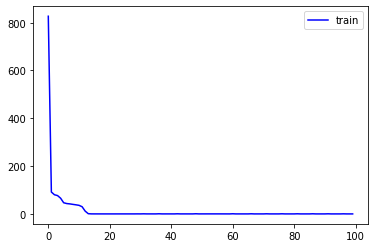

In [304]:
# Plot train loss and valid loss vs epochs
fig, ax1 = plt.subplots(1,1)
x = range(0, len(loss_list))
ax1.plot(x, loss_list, color='b', label='train')
#ax1.plot(x, validation_loss_list, color='r', label='valid')
ax1.legend()

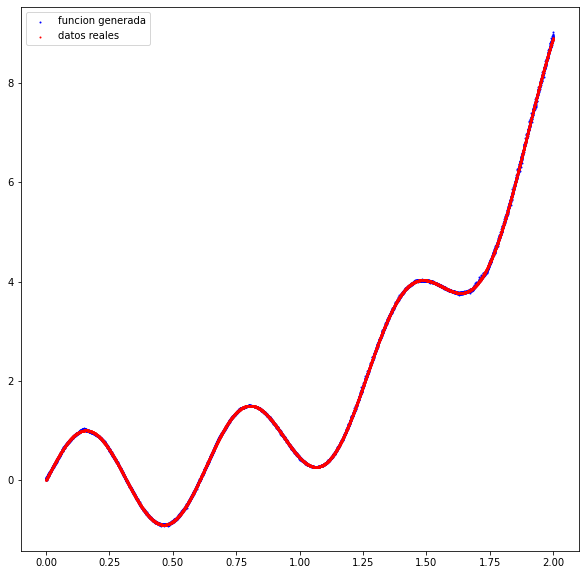

In [305]:
plt.figure(figsize=(10,10))
plt.scatter(dataset[:,0], running_y_score, label='funcion generada', c='blue', s=1)
plt.scatter(dataset[:,0], dataset[:,1], label='datos reales', c='red', s=1)
plt.legend()

De los gráficos anteriores podemos ver que la Red está haciendo overfitting, ya que se está aprendiendo de memoria la función dentro del intervalo 0,2.

Agrego Regularización L2

In [296]:
nnet = NNet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001, weight_decay=25e-3)

In [297]:
nnet.to(device)

loss_list = []
validation_loss_list = []
for epoch in range(RANGE):
    running_loss = 0
    running_y_score = []
    running_validation_loss = 0
    running_validation_y_score = []
    y_label = []
    
    #### TRAINING ####
    for i, data in enumerate(train_dataloader):
        X_batch, y_batch = data #  Datos del batch
        X_batch = X_batch.to(device).float()
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = nnet(X_batch)

        # backprop
        loss = loss_function(y_batch_score, Y_batch)  # Calcula el loss
        loss.backward()  # Hacer los gradientes del loss

        # actualizacion de parametros
        optimizer.step()

        # metrics
        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())

    # Metrics
    loss_list.append(running_loss)
    print(f"Epoch {epoch} | Training loss: {running_loss}")

Epoch 0 | Training loss: 935.2953335642815
Epoch 1 | Training loss: 85.27918720245361
Epoch 2 | Training loss: 81.75405350327492
Epoch 3 | Training loss: 81.61565592885017
Epoch 4 | Training loss: 81.58612886071205
Epoch 5 | Training loss: 81.56845504045486
Epoch 6 | Training loss: 81.55111089348793
Epoch 7 | Training loss: 81.54748266935349
Epoch 8 | Training loss: 81.53663411736488
Epoch 9 | Training loss: 81.52129945158958
Epoch 10 | Training loss: 81.52173271775246
Epoch 11 | Training loss: 81.47778964042664
Epoch 12 | Training loss: 81.45994195342064
Epoch 13 | Training loss: 81.44738608598709
Epoch 14 | Training loss: 81.42913526296616
Epoch 15 | Training loss: 81.4188024699688
Epoch 16 | Training loss: 81.3962234556675
Epoch 17 | Training loss: 81.38541132211685
Epoch 18 | Training loss: 81.37401133775711
Epoch 19 | Training loss: 81.36018109321594
Epoch 20 | Training loss: 81.35624796152115
Epoch 21 | Training loss: 81.34126818180084
Epoch 22 | Training loss: 81.32580387592316


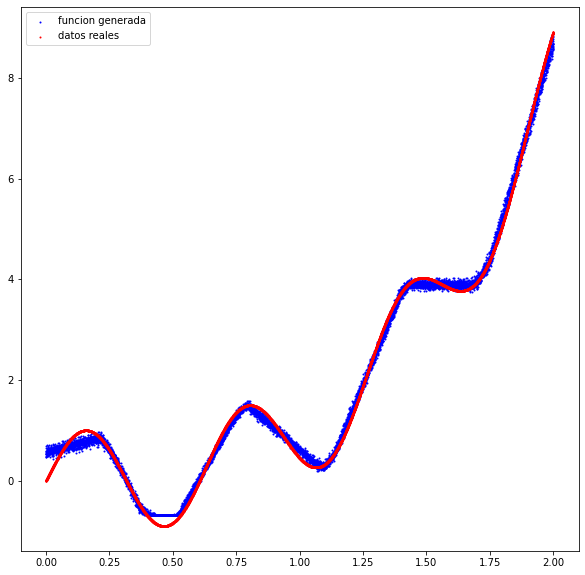

In [299]:
plt.figure(figsize=(10,10))
plt.scatter(dataset[:,0], running_y_score, label='funcion generada', c='blue', s=1)
plt.scatter(dataset[:,0], dataset[:,1], label='datos reales', c='red', s=1)
plt.legend()

Pruebo regularizar con Dropout

In [33]:
class NNetDropout(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=20, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.linear_4 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_4 = torch.nn.ReLU()
        self.linear_5 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_5 = torch.nn.ReLU()
        self.linear_6 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_6 = torch.nn.ReLU()
        self.linear_7 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_7 = torch.nn.ReLU()
        self.linear_8 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_8 = torch.nn.ReLU()
        self.linear_9 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_9 = torch.nn.ReLU()
        self.linear_10 = torch.nn.Linear(in_features=20, out_features=20, bias=True)
        self.relu_10 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=20, out_features=1, bias=True)

        self.dropout = torch.nn.Dropout(0.25)

    def forward(self, x): # x.shape -> 64x1
        x = self.linear_1(x) # 64x20
        x = self.relu_1(x) # 64x20
        x = self.linear_2(x) # 64x20
        x = self.relu_2(x) # 64x20
        x = self.linear_3(x) # 64x20
        x = self.relu_3(x) # 64x20
        x = self.linear_4(x) # 64x20
        x = self.relu_4(x) # 64x20
        x = self.linear_5(x) # 64x20
        x = self.relu_5(x) # 64x20
        x = self.linear_6(x) # 64x20
        x = self.relu_6(x) # 64x20
        x = self.linear_7(x) # 64x20
        x = self.relu_7(x) # 64x20
        x = self.linear_8(x) # 64x20
        x = self.relu_8(x) # 64x20
        x = self.linear_9(x) # 64x20
        x = self.relu_9(x) # 64x20
        x = self.linear_10(x) # 64x20
        x = self.relu_10(x) # 64x20
        x = self.dropout(x) # Regularization
        x = self.output(x) # 64x1
        return x

In [34]:
nnet = NNetDropout()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()

In [35]:
nnet.to(device)

loss_list = []
validation_loss_list = []
for epoch in range(RANGE):
    running_loss = 0
    running_y_score = []
    running_validation_loss = 0
    running_validation_y_score = []
    y_label = []
    
    #### TRAINING ####
    for i, data in enumerate(train_dataloader):
        X_batch, y_batch = data #  Datos del batch
        X_batch = X_batch.to(device).float()
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = nnet(X_batch)

        # backprop
        loss = loss_function(y_batch_score, Y_batch)  # Calcula el loss
        loss.backward()  # Hacer los gradientes del loss

        # actualizacion de parametros
        optimizer.step()

        # metrics
        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())

    # Metrics
    loss_list.append(running_loss)
    print(f"Epoch {epoch} | Training loss: {running_loss}")

Epoch 0 | Training loss: 842.802661895752
Epoch 1 | Training loss: 135.81934067606926
Epoch 2 | Training loss: 116.45798885822296
Epoch 3 | Training loss: 104.71069160103798
Epoch 4 | Training loss: 91.06786208227277
Epoch 5 | Training loss: 81.0301653072238
Epoch 6 | Training loss: 82.46015483140945
Epoch 7 | Training loss: 85.96385952830315
Epoch 8 | Training loss: 80.37133829295635
Epoch 9 | Training loss: 80.85931564867496
Epoch 10 | Training loss: 76.86453515291214
Epoch 11 | Training loss: 78.69060416519642
Epoch 12 | Training loss: 81.36358519643545
Epoch 13 | Training loss: 78.03358621895313
Epoch 14 | Training loss: 77.82150003314018
Epoch 15 | Training loss: 77.52907518297434
Epoch 16 | Training loss: 75.64952728152275
Epoch 17 | Training loss: 73.06393837928772
Epoch 18 | Training loss: 80.04746458865702
Epoch 19 | Training loss: 74.84441964328289
Epoch 20 | Training loss: 74.12546993046999
Epoch 21 | Training loss: 73.82398648560047
Epoch 22 | Training loss: 74.869469985365

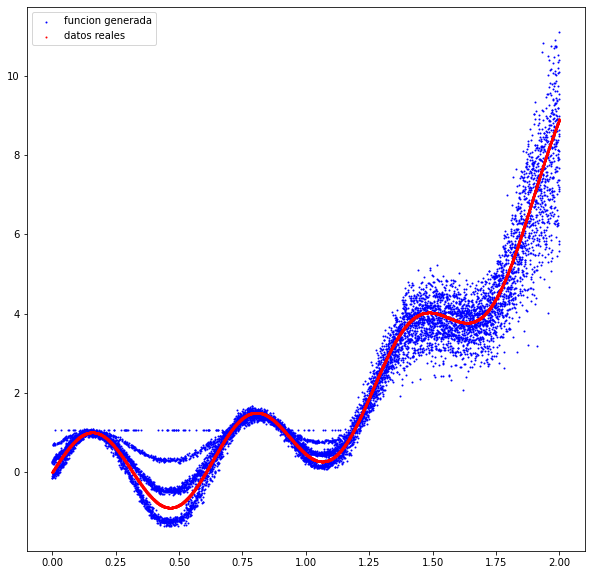

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(dataset[:,0], running_y_score, label='funcion generada', c='blue', s=1)
plt.scatter(dataset[:,0], dataset[:,1], label='datos reales', c='red', s=1)
plt.legend()

#### Punto 3

EDA

In [2]:
df = pd.read_csv('./dataset_2.csv')

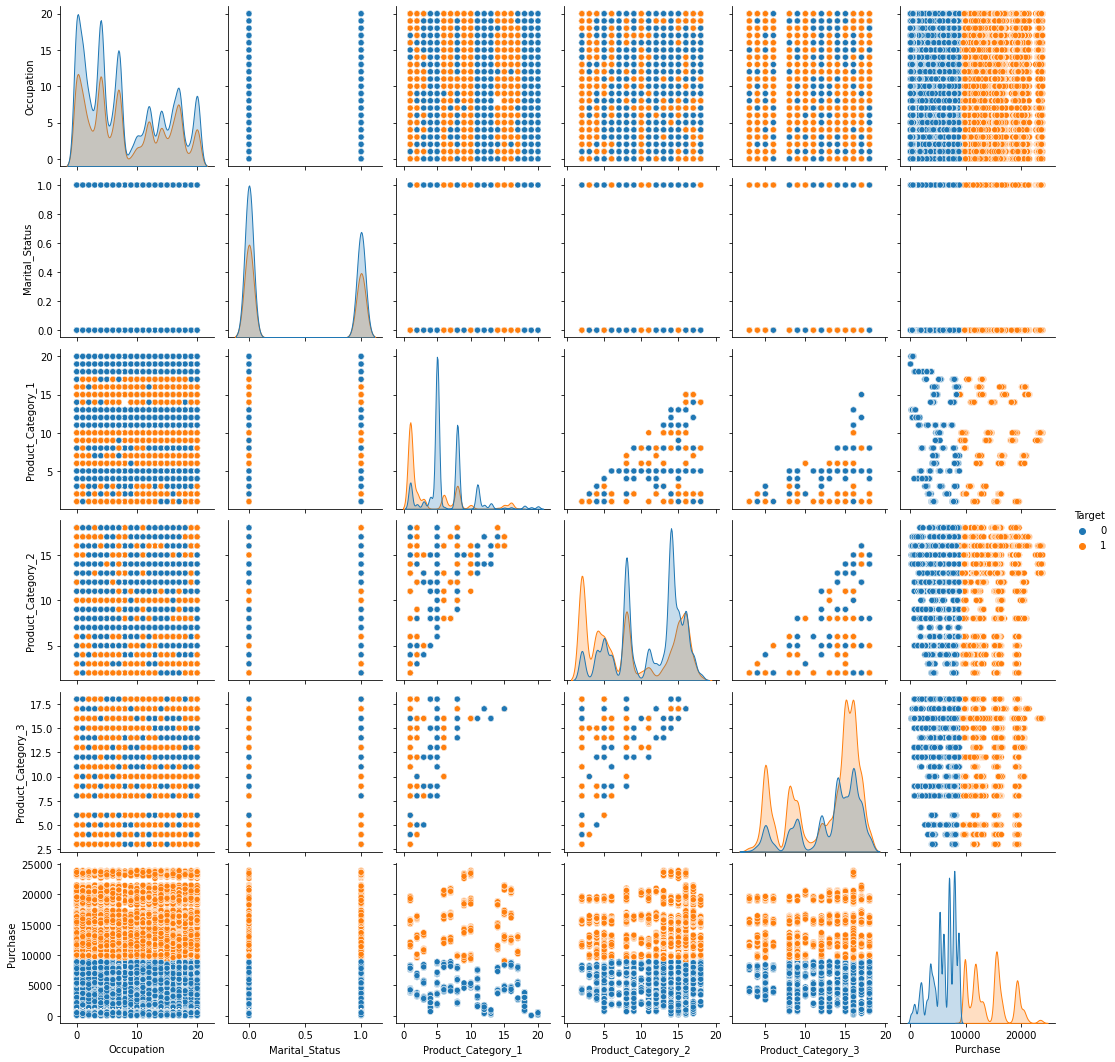

In [3]:
pairplot = pd.read_csv('./dataset_2.csv')
pairplot["Target"] = pairplot.Purchase.apply(lambda x: 1 if x >= 9000 else 0)
pairplot.drop(["User_ID", "Product_ID"], inplace=True, axis=1)
sns.pairplot(pairplot, hue="Target")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [75]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [76]:
df.City_Category.value_counts()

B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

In [77]:
df.Gender.value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [78]:
df.Age.value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

In [14]:
df.Stay_In_Current_City_Years.value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

In [15]:
df.Marital_Status.value_counts()

0    324731
1    225337
Name: Marital_Status, dtype: int64

Aca vemos que:
- A la columna Gender se le puede hacer Binary Encoding
- A la columna City_Category se le puede hacer OHE
- A la columna Age se le puede hacer OHE
- A la columna Stay_In_Current_City_Years se le puede hacer OHE

In [7]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [5]:
df.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

Aca vemos que hay 2 columnas con muchos nulls, Product_Category_3 tiene aprox. 70% y Product_Category_2 tiene aprox. 30%. Ambas columnas son candidatas a ser ignoradas para el modelo.

In [3]:
df = df.dropna()
df.shape

(166821, 12)

In [4]:
df["Gender"] = df.Gender.apply(lambda x: 1 if x == 'M' else 0)

In [5]:
category_dummies = pd.get_dummies(df["City_Category"], prefix="City_Category")
df = pd.concat([df, category_dummies], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166821 entries, 1 to 545914
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     166821 non-null  int64  
 1   Product_ID                  166821 non-null  object 
 2   Gender                      166821 non-null  int64  
 3   Age                         166821 non-null  object 
 4   Occupation                  166821 non-null  int64  
 5   City_Category               166821 non-null  object 
 6   Stay_In_Current_City_Years  166821 non-null  object 
 7   Marital_Status              166821 non-null  int64  
 8   Product_Category_1          166821 non-null  int64  
 9   Product_Category_2          166821 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    166821 non-null  int64  
 12  City_Category_A             166821 non-null  uint8  
 13  City_Category_

In [6]:
age_dummies = pd.get_dummies(df["Age"], prefix="Age")
df = pd.concat([df, age_dummies], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166821 entries, 1 to 545914
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     166821 non-null  int64  
 1   Product_ID                  166821 non-null  object 
 2   Gender                      166821 non-null  int64  
 3   Age                         166821 non-null  object 
 4   Occupation                  166821 non-null  int64  
 5   City_Category               166821 non-null  object 
 6   Stay_In_Current_City_Years  166821 non-null  object 
 7   Marital_Status              166821 non-null  int64  
 8   Product_Category_1          166821 non-null  int64  
 9   Product_Category_2          166821 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    166821 non-null  int64  
 12  City_Category_A             166821 non-null  uint8  
 13  City_Category_

In [7]:
city_dummies = pd.get_dummies(df["Stay_In_Current_City_Years"], prefix="City_Years")
df = pd.concat([df, city_dummies], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166821 entries, 1 to 545914
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     166821 non-null  int64  
 1   Product_ID                  166821 non-null  object 
 2   Gender                      166821 non-null  int64  
 3   Age                         166821 non-null  object 
 4   Occupation                  166821 non-null  int64  
 5   City_Category               166821 non-null  object 
 6   Stay_In_Current_City_Years  166821 non-null  object 
 7   Marital_Status              166821 non-null  int64  
 8   Product_Category_1          166821 non-null  int64  
 9   Product_Category_2          166821 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    166821 non-null  int64  
 12  City_Category_A             166821 non-null  uint8  
 13  City_Category_

Ahora lo que voy a hacer es un Binary Encoding de la columna Purchase

In [8]:
df["Target"] = df.Purchase.apply(lambda x: 1 if x >= 9000 else 0)

In [9]:
y = df["Target"]
X = df.drop(["Target", "Purchase", "City_Category", "Age", "Stay_In_Current_City_Years", "User_ID", "Product_ID"], axis=1)

In [86]:
y.head()

1     1
6     1
13    1
14    0
16    1
Name: Target, dtype: int64

In [87]:
X.head()

,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,City_Category_A,City_Category_B,City_Category_C,Age_0-17,...,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Years_0,City_Years_1,City_Years_2,City_Years_3,City_Years_4+
1,0,10,0,1,6.0,14.0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6,1,7,1,1,8.0,17.0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
13,1,20,1,1,2.0,5.0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
14,0,9,0,5,8.0,14.0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
16,0,9,0,2,3.0,4.0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [10]:
## Normalizacion
X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))
X_norm.describe()

,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,City_Category_A,City_Category_B,City_Category_C,Age_0-17,...,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Years_0,City_Years_1,City_Years_2,City_Years_3,City_Years_4+
count,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,...,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000
mean,0.774645,0.408944,0.402839,0.124483,0.349777,0.644550,0.248884,0.415074,0.336043,0.029211,...,0.401280,0.199525,0.080170,0.066934,0.035157,0.134210,0.349398,0.188915,0.175446,0.152031
std,0.417817,0.324376,0.490470,0.183855,0.321449,0.275023,0.432367,0.492736,0.472355,0.168398,...,0.490159,0.399645,0.271557,0.249908,0.184178,0.340879,0.476781,0.391442,0.380349,0.359052
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.100000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.350000,0.000000,0.000000,0.285714,0.733333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.700000,1.000000,0.214286,0.571429,0.866667,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
n = X_norm.shape[0]
idx = np.random.permutation(np.arange(0, n))
train_idx = idx[0:int(0.8*n)]
valid_idx = idx[int(0.8*n):]
print(len(train_idx))
print(len(valid_idx))

133456
33365


In [12]:
y_ = y.to_numpy()
X_norm_ = X_norm.to_numpy()

In [13]:
X_train = X_norm_[train_idx,:]
y_train = y_[train_idx]

X_valid = X_norm_[valid_idx,:]
y_valid = y_[valid_idx]

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(133456, 21)
(133456,)
(33365, 21)
(33365,)


##### NNet sin embedding

In [15]:
class MyDataset(Dataset):

    def __init__(self, X, y):
      super().__init__()
      self.X = X
      self.y = y

    def __len__(self):
      return self.X.shape[0]

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

In [16]:
train = MyDataset(X_train, y_train)
validation = MyDataset(X_valid, y_valid)

In [19]:
class NNet(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=21, out_features=100, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_3 = torch.nn.ReLU()
    self.linear_4 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_4 = torch.nn.ReLU()
    self.linear_5 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_5 = torch.nn.ReLU()
    self.linear_6 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_6 = torch.nn.ReLU()  
    self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)

  
  def forward(self, x): # x.shape -> 64x21
    x = self.linear_1(x) # 64x100
    x = self.relu_1(x) # 64x100
    x = self.linear_2(x) # 64x100
    x = self.relu_2(x) # 64x100
    x = self.linear_3(x)  # 64x100
    x = self.relu_3(x)  # 64x100
    x = self.linear_4(x)  #64x100
    x = self.relu_4(x)  #64x100
    x = self.linear_5(x)  #64x100
    x = self.relu_5(x)  #64x100
    x = self.linear_6(x)  #64x100
    x = self.relu_6(x)  #64x100
    x = self.output(x)  #64x1
    return x

In [20]:
device = ""
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

In [21]:
EPOCHS = 100

In [22]:
def entrenar(nnet, optimizer, loss_function, train_dataloader, valid_dataloader, device, epochs=100):
    nnet.to(device)

    loss_list = []
    train_auc = []
    validation_loss_list = []
    validation_auc = []
    for epoch in range(EPOCHS):

        running_loss = 0
        running_y_score = []
        running_y_label = []
        running_validation_loss = 0
        running_validation_y_score = []
        running_validation_y_label = []

        for i, data in enumerate(train_dataloader):
            X_batch, y_batch = data # datos del batch
            X_batch = X_batch.to(device).float()
            Y_batch = y_batch.to(device).float()

            # forward
            optimizer.zero_grad()
            y_batch_score = nnet(X_batch).reshape(-1)
            y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

            # backprop
            loss = loss_function(y_batch_score, Y_batch) # calcula el loss
            loss.backward() # hacer los gradientes del loss

            # actualizacion de parametros
            optimizer.step()

            # metrics
            running_loss += loss.item()
            running_y_score += list(y_batch_score.detach().cpu().numpy())
            running_y_label += list(Y_batch.detach().cpu().numpy())

        # metrics
        loss_list.append(running_loss)
        fpt, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
        auc = metrics.auc(fpt, tpr)
        train_auc.append(auc)
        print(f"Epoch {epoch} | Training loss: {running_loss} | AUC: {auc}")

        #### VALIDATION ####
        nnet.eval()
        with torch.no_grad():
            for i, data in enumerate(valid_dataloader): 
                # Datos del batch
                X_validation_batch, y_validation_batch = data
                X_validation_batch = X_validation_batch.to(device).float()
                Y_validation_batch = y_validation_batch.to(device).float()

                # Forward
                y_validation_batch_score = nnet(X_validation_batch).reshape(-1)
                y_validation_batch_hat = torch.sigmoid(y_validation_batch_score).reshape(-1)

                validation_loss = loss_function(y_validation_batch_score, Y_validation_batch) #  Calcula el loss

                # Acumular validation loss
                running_validation_loss += validation_loss.item()

                # Acumular metrics y_score and y
                running_validation_y_score += list(y_validation_batch_score.detach().cpu().numpy())
                running_validation_y_label += list(Y_validation_batch.detach().cpu().numpy())

            # Calcular las metricas (AUC)
            validation_loss_list.append(running_validation_loss)
            fpt_v, tpr_v, _ = metrics.roc_curve(running_validation_y_label, running_validation_y_score)
            auc_v = metrics.auc(fpt_v, tpr_v)
            validation_auc.append(auc_v)
            print(f"Epoch {epoch} | Validation loss: {running_validation_loss} | AUC: {auc_v}")
    
    return loss_list, validation_loss_list, train_auc, validation_auc

In [27]:
nnet = NNet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(validation, batch_size=128, shuffle=True)

loss_list, validation_loss_list, train_auc, validation_auc = entrenar(nnet, optimizer, loss_function, train_dataloader, valid_dataloader, device, 100)

Epoch 0 | Training loss: 63030.58950805664 | AUC: 0.7906574270274818
Epoch 0 | Validation loss: 14024.138637542725 | AUC: 0.822755723325776
Epoch 1 | Training loss: 56634.759479522705 | AUC: 0.8176699898632817
Epoch 1 | Validation loss: 14181.91191482544 | AUC: 0.8247217697723079
Epoch 2 | Training loss: 56128.642723083496 | AUC: 0.8216158884955819
Epoch 2 | Validation loss: 14056.680305480957 | AUC: 0.8244730400714771
Epoch 3 | Training loss: 57710.32106399536 | AUC: 0.8153620545294721
Epoch 3 | Validation loss: 14135.607166290283 | AUC: 0.8258778757026048
Epoch 4 | Training loss: 56188.634773254395 | AUC: 0.8236984843155624
Epoch 4 | Validation loss: 13907.694637298584 | AUC: 0.8274168502594813
Epoch 5 | Training loss: 55883.244174957275 | AUC: 0.8261663437109928
Epoch 5 | Validation loss: 13878.439628601074 | AUC: 0.8291517884831925
Epoch 6 | Training loss: 55762.772243499756 | AUC: 0.8276529185756546
Epoch 6 | Validation loss: 13848.862041473389 | AUC: 0.8307684990665813
Epoch 7 | 

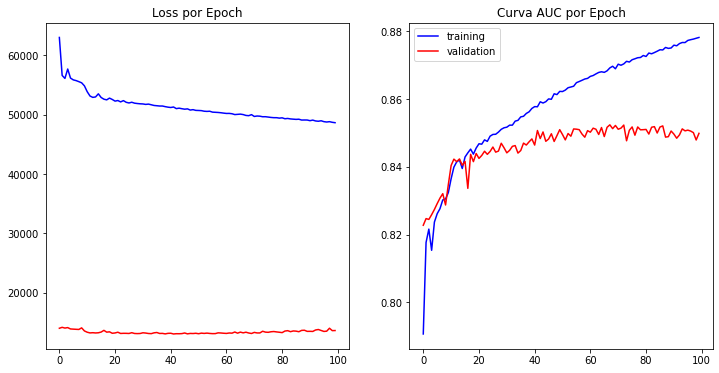

In [29]:
fig = plt.figure(figsize=(25, 6))

iax0 = fig.add_subplot(141)
iax0.set_title('Loss por Epoch')
x = range(0, len(loss_list))
iax0.plot(x, loss_list, label='training', c='blue')
iax0.plot(x, validation_loss_list, label='validation', c='red')

iax1 = fig.add_subplot(142)
iax1.set_title('Curva AUC por Epoch')
x = range(0, len(train_auc))
iax1.plot(x, train_auc, label='training', c='blue')
iax1.plot(x, validation_auc, label='validation', c='red')

plt.legend()

Cambio el Learning Rate

In [24]:
nnet = NNet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.01)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(validation, batch_size=128, shuffle=True)

loss_list, validation_loss_list, train_auc, validation_auc = entrenar(nnet, optimizer, loss_function, train_dataloader, valid_dataloader, device, 100)

Epoch 0 | Training loss: 64014.73363113403 | AUC: 0.7845572343616298
Epoch 0 | Validation loss: 17960.20845413208 | AUC: 0.7563579528564179
Epoch 1 | Training loss: 59033.45738220215 | AUC: 0.8066095180954967
Epoch 1 | Validation loss: 15303.30525970459 | AUC: 0.8014755293640381
Epoch 2 | Training loss: 57461.97352218628 | AUC: 0.8155702005315081
Epoch 2 | Validation loss: 15998.55460357666 | AUC: 0.7991652028480875
Epoch 3 | Training loss: 60585.311685562134 | AUC: 0.7850988292436594
Epoch 3 | Validation loss: 14375.205142974854 | AUC: 0.7708387615711847
Epoch 4 | Training loss: 57282.181495666504 | AUC: 0.7762417559868495
Epoch 4 | Validation loss: 14309.370052337646 | AUC: 0.7791347759045901
Epoch 5 | Training loss: 57434.722496032715 | AUC: 0.7762313548426929
Epoch 5 | Validation loss: 14299.60813331604 | AUC: 0.7791181148109078
Epoch 6 | Training loss: 57257.224168777466 | AUC: 0.776911648777469
Epoch 6 | Validation loss: 14304.729469299316 | AUC: 0.7791707647328643
Epoch 7 | Trai

In [25]:
nnet = NNet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(validation, batch_size=128, shuffle=True)

loss_list, validation_loss_list, train_auc, validation_auc = entrenar(nnet, optimizer, loss_function, train_dataloader, valid_dataloader, device, 100)

Epoch 0 | Training loss: 76950.98861312866 | AUC: 0.7164701205481688
Epoch 0 | Validation loss: 17191.867572784424 | AUC: 0.7798744587968635
Epoch 1 | Training loss: 64150.35209655762 | AUC: 0.7906255439145766
Epoch 1 | Validation loss: 14781.574405670166 | AUC: 0.8025303226197817
Epoch 2 | Training loss: 57550.341796875 | AUC: 0.8051078660331736
Epoch 2 | Validation loss: 14076.380840301514 | AUC: 0.8186392287698208
Epoch 3 | Training loss: 56382.77265548706 | AUC: 0.815916517247211
Epoch 3 | Validation loss: 13993.884262084961 | AUC: 0.8224984229820221
Epoch 4 | Training loss: 56118.20452308655 | AUC: 0.8180603653997072
Epoch 4 | Validation loss: 14040.474884033203 | AUC: 0.8228132637294004
Epoch 5 | Training loss: 55974.949993133545 | AUC: 0.8199792914595224
Epoch 5 | Validation loss: 14000.401676177979 | AUC: 0.8238119256700001
Epoch 6 | Training loss: 55871.691509246826 | AUC: 0.8211308701390476
Epoch 6 | Validation loss: 13962.541933059692 | AUC: 0.8251181113314826
Epoch 7 | Trai

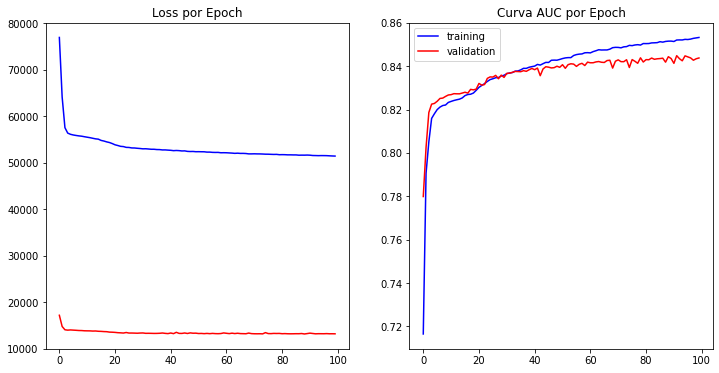

In [26]:
fig = plt.figure(figsize=(25, 6))

iax0 = fig.add_subplot(141)
iax0.set_title('Loss por Epoch')
x = range(0, len(loss_list))
iax0.plot(x, loss_list, label='training', c='blue')
iax0.plot(x, validation_loss_list, label='validation', c='red')

iax1 = fig.add_subplot(142)
iax1.set_title('Curva AUC por Epoch')
x = range(0, len(train_auc))
iax1.plot(x, train_auc, label='training', c='blue')
iax1.plot(x, validation_auc, label='validation', c='red')

plt.legend()

Pruebo una arquitectura mas potente

In [30]:
class NNetPower(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=21, out_features=500, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features=500, out_features=500, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features=500, out_features=500, bias=True)
    self.relu_3 = torch.nn.ReLU()
    self.linear_4 = torch.nn.Linear(in_features=500, out_features=500, bias=True)
    self.relu_4 = torch.nn.ReLU()
    self.linear_5 = torch.nn.Linear(in_features=500, out_features=500, bias=True)
    self.relu_5 = torch.nn.ReLU()
    self.linear_6 = torch.nn.Linear(in_features=500, out_features=500, bias=True)
    self.relu_6 = torch.nn.ReLU()
    self.linear_7 = torch.nn.Linear(in_features=500, out_features=500, bias=True)
    self.relu_7 = torch.nn.ReLU()  
    self.linear_8 = torch.nn.Linear(in_features=500, out_features=500, bias=True)
    self.relu_8 = torch.nn.ReLU()  
    self.linear_9 = torch.nn.Linear(in_features=500, out_features=100, bias=True)
    self.relu_9 = torch.nn.ReLU()  
    self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)

  
  def forward(self, x): # x.shape -> 64x21
    x = self.linear_1(x) # 64x500
    x = self.relu_1(x) # 64x500
    x = self.linear_2(x) # 64x500
    x = self.relu_2(x) # 64x500
    x = self.linear_3(x)  # 64x500
    x = self.relu_3(x)  # 64x500
    x = self.linear_4(x)  #64x500
    x = self.relu_4(x)  #64x500
    x = self.linear_5(x)  #64x500
    x = self.relu_5(x)  #64x500
    x = self.linear_6(x)  #64x500
    x = self.relu_6(x)  #64x500
    x = self.linear_7(x)  #64x500
    x = self.relu_7(x)  #64x500
    x = self.linear_8(x)  #64x500
    x = self.relu_8(x)  #64x500
    x = self.linear_9(x)  #64x100
    x = self.relu_9(x)  #64x100
    x = self.output(x)  #64x1
    return x

In [31]:
nnet = NNetPower()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(validation, batch_size=128, shuffle=True)

loss_list, validation_loss_list, train_auc, validation_auc = entrenar(nnet, optimizer, loss_function, train_dataloader, valid_dataloader, device, 100)

Epoch 0 | Training loss: 67434.20032119751 | AUC: 0.7714449453906571
Epoch 0 | Validation loss: 14287.35615158081 | AUC: 0.8088564745533537
Epoch 1 | Training loss: 56843.72286987305 | AUC: 0.8161316020285532
Epoch 1 | Validation loss: 14322.743682861328 | AUC: 0.823773219032799
Epoch 2 | Training loss: 56365.05324935913 | AUC: 0.8201045548999928
Epoch 2 | Validation loss: 13948.840595245361 | AUC: 0.8256381791248548
Epoch 3 | Training loss: 55657.53718948364 | AUC: 0.823552121696449
Epoch 3 | Validation loss: 13536.05228805542 | AUC: 0.8321845503335341
Epoch 4 | Training loss: 54144.59211349487 | AUC: 0.8313512687199573
Epoch 4 | Validation loss: 13592.057525634766 | AUC: 0.8347489280241305
Epoch 5 | Training loss: 53726.077377319336 | AUC: 0.8344552530509628
Epoch 5 | Validation loss: 13447.383045196533 | AUC: 0.8376407928344182
Epoch 6 | Training loss: 53185.94538497925 | AUC: 0.8378392900000446
Epoch 6 | Validation loss: 13390.426681518555 | AUC: 0.8383259365240906
Epoch 7 | Traini

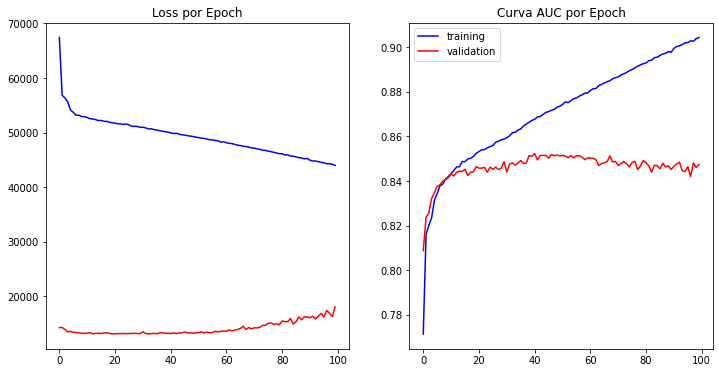

In [32]:
fig = plt.figure(figsize=(25, 6))

iax0 = fig.add_subplot(141)
iax0.set_title('Loss por Epoch')
x = range(0, len(loss_list))
iax0.plot(x, loss_list, label='training', c='blue')
iax0.plot(x, validation_loss_list, label='validation', c='red')

iax1 = fig.add_subplot(142)
iax1.set_title('Curva AUC por Epoch')
x = range(0, len(train_auc))
iax1.plot(x, train_auc, label='training', c='blue')
iax1.plot(x, validation_auc, label='validation', c='red')

plt.legend()

In [37]:
class NNetPower2(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=21, out_features=100, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_3 = torch.nn.ReLU()
    self.linear_4 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_4 = torch.nn.ReLU()
    self.linear_5 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_5 = torch.nn.ReLU()
    self.linear_6 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_6 = torch.nn.ReLU()
    self.linear_7 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_7 = torch.nn.ReLU()  
    self.linear_8 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_8 = torch.nn.ReLU()  
    self.linear_9 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_9 = torch.nn.ReLU()
    self.linear_10 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_10 = torch.nn.ReLU()  
    self.linear_11 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_11 = torch.nn.ReLU()  
    self.linear_12 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_12 = torch.nn.ReLU()
    self.linear_13 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_13 = torch.nn.ReLU()  
    self.linear_14 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_14 = torch.nn.ReLU()  
    self.linear_15 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_15 = torch.nn.ReLU()  
    self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)

  
  def forward(self, x): # x.shape -> 64x21
    x = self.linear_1(x) # 64x100
    x = self.relu_1(x) # 64x100
    x = self.linear_2(x) # 64x100
    x = self.relu_2(x) # 64x100
    x = self.linear_3(x)  # 64x100
    x = self.relu_3(x)  # 64x100
    x = self.linear_4(x)  #64x100
    x = self.relu_4(x)  #64x100
    x = self.linear_5(x)  #64x100
    x = self.relu_5(x)  #64x100
    x = self.linear_6(x)  #64x100
    x = self.relu_6(x)  #64x100
    x = self.linear_7(x)  #64x100
    x = self.relu_7(x)  #64x100
    x = self.linear_8(x)  #64x100
    x = self.relu_8(x)  #64x100
    x = self.linear_9(x)  #64x100
    x = self.relu_9(x)  #64x100
    x = self.linear_10(x)  #64x100
    x = self.relu_10(x)  #64x100
    x = self.linear_11(x)  #64x100
    x = self.relu_11(x)  #64x100
    x = self.linear_12(x)  #64x100
    x = self.relu_12(x)  #64x100
    x = self.linear_13(x)  #64x100
    x = self.relu_13(x)  #64x100
    x = self.linear_14(x)  #64x100
    x = self.relu_14(x)  #64x100
    x = self.linear_15(x)  #64x100
    x = self.relu_15(x)  #64x100
    x = self.output(x)  #64x1
    return x

In [38]:
nnet = NNetPower2()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(validation, batch_size=128, shuffle=True)

loss_list, validation_loss_list, train_auc, validation_auc = entrenar(nnet, optimizer, loss_function, train_dataloader, valid_dataloader, device, 100)

Epoch 0 | Training loss: 77140.9824295044 | AUC: 0.7143030928896048
Epoch 0 | Validation loss: 17241.66537475586 | AUC: 0.7855423322179257
Epoch 1 | Training loss: 61671.51943588257 | AUC: 0.7916157044679444
Epoch 1 | Validation loss: 14668.86304473877 | AUC: 0.8004103116087393
Epoch 2 | Training loss: 58030.55581283569 | AUC: 0.7969439237363125
Epoch 2 | Validation loss: 14178.24535369873 | AUC: 0.808411783153689
Epoch 3 | Training loss: 56611.050300598145 | AUC: 0.8114037634064196
Epoch 3 | Validation loss: 14169.367374420166 | AUC: 0.8185611050471762
Epoch 4 | Training loss: 56426.4068031311 | AUC: 0.8153336043265444
Epoch 4 | Validation loss: 14046.459980010986 | AUC: 0.8209136333695202
Epoch 5 | Training loss: 56250.30939102173 | AUC: 0.8172190241743914
Epoch 5 | Validation loss: 13959.501598358154 | AUC: 0.8224544539110261
Epoch 6 | Training loss: 56141.434299468994 | AUC: 0.8181524812628538
Epoch 6 | Validation loss: 14067.013134002686 | AUC: 0.82240860736739
Epoch 7 | Training 

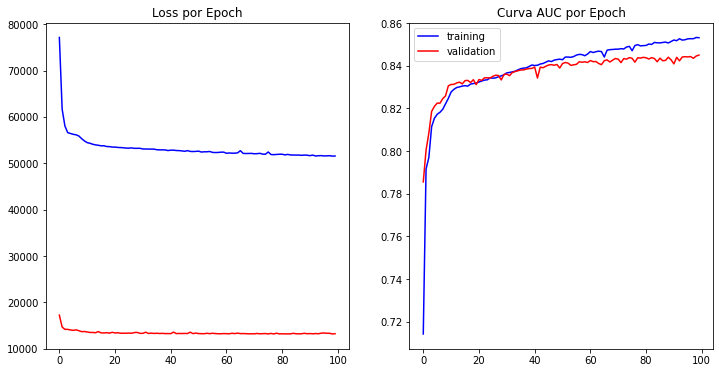

In [39]:
fig = plt.figure(figsize=(25, 6))

iax0 = fig.add_subplot(141)
iax0.set_title('Loss por Epoch')
x = range(0, len(loss_list))
iax0.plot(x, loss_list, label='training', c='blue')
iax0.plot(x, validation_loss_list, label='validation', c='red')

iax1 = fig.add_subplot(142)
iax1.set_title('Curva AUC por Epoch')
x = range(0, len(train_auc))
iax1.plot(x, train_auc, label='training', c='blue')
iax1.plot(x, validation_auc, label='validation', c='red')

plt.legend()

##### NNet con embedding

In [52]:
user_id = df["User_ID"]
product_id = df["Product_ID"]

In [53]:
unique_user = np.unique(user_id)
index_user = np.arange(0, len(unique_user))
user_id_to_index = {key: value for key, value in zip(unique_user, index_user)}

unique_product = np.unique(product_id)
index_product = np.arange(0, len(product_id))
product_id_to_index = {key: value for key,value in zip(unique_product, index_product)}

users_idx = np.array([user_id_to_index[user] for user in user_id])
products_idx = np.array([product_id_to_index[product] for product in product_id])

In [54]:
print(max(users_idx))
print(min(users_idx))
print(len(users_idx))

print(max(products_idx))
print(min(products_idx))
print(len(products_idx))

5869
0
166821
527
0
166821


In [51]:
class CustomDatasetWithEmb(Dataset):

  def __init__(self, X, users_idx, products_idx, y):
    super().__init__()
    self.X = X
    self.users_idx = users_idx
    self.products_idx = products_idx
    self.y = y
  
  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
      return self.X[idx], self.users_idx[idx], self.products_idx[idx], self.y[idx]

In [55]:
users_index_train = users_idx[train_idx]
users_index_val = users_idx[valid_idx]

products_index_train = products_idx[train_idx]
products_index_val = products_idx[valid_idx]

In [56]:
train = CustomDatasetWithEmb(X_train, users_index_train, products_index_train, y_train)
valid = CustomDatasetWithEmb(X_valid, users_index_val, products_index_val, y_valid)

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

In [58]:
class NNetWithEmbeddings(torch.nn.Module):

  def __init__(self, number_of_users, d1, number_of_products, d2):
    super().__init__()
    self.users_embedding = torch.nn.Embedding(num_embeddings=number_of_users, embedding_dim=d1)
    self.products_embedding = torch.nn.Embedding(num_embeddings=number_of_products, embedding_dim=d2)
    self.linear_1 = torch.nn.Linear(in_features=(21+d1+d2), out_features=100, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_3 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_3 = torch.nn.ReLU()
    self.linear_4 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_4 = torch.nn.ReLU()
    self.linear_5 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_5 = torch.nn.ReLU()
    self.linear_6 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_6 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)

  
  def forward(self, x, user_idx, product_idx):
    user_emb = self.users_embedding(user_idx)  # (64, d1)
    prod_emb = self.products_embedding(product_idx)  # (64, d2)

    final_input = torch.cat([x, user_emb, prod_emb], dim=1)  # (64, 21+d1+d2)

    x = self.linear_1(final_input) 
    x = self.relu_1(x) 
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.linear_3(x)
    x = self.relu_3(x)
    x = self.linear_4(x)
    x = self.relu_4(x)
    x = self.linear_5(x)
    x = self.relu_5(x)
    x = self.linear_6(x)
    x = self.relu_6(x)
    x = self.output(x)
    return x

In [139]:
nnet2 = NNetWithEmbeddings(number_of_users=len(users_idx), d1=8, number_of_products=len(products_idx), d2=8)
optimizer = torch.optim.Adam(nnet2.parameters(), lr=0.001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")
EPOCHS = 100
print(nnet2)

NNetWithEmbeddings(
  (users_embedding): Embedding(166821, 8)
  (products_embedding): Embedding(166821, 8)
  (linear_1): Linear(in_features=37, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=100, out_features=100, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=100, out_features=100, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=100, out_features=100, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=100, out_features=100, bias=True)
  (relu_6): ReLU()
  (output): Linear(in_features=100, out_features=1, bias=True)
)


In [140]:
nnet2.to(device)

loss_list = []
train_auc = []
validation_loss_list = []
validation_auc = []
for epoch in range(EPOCHS):

    running_loss = 0
    running_y_score = []
    running_y_label = []
    running_validation_loss = 0
    running_validation_y_score = []
    running_validation_y_label = []

    #### TRAINING ####
    for i, data in enumerate(train_dataloader):

        # datos del batch
        X_batch, user_idx_batch, product_idx_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        user_idx_batch = user_idx_batch.to(device)
        product_idx_batch = product_idx_batch.to(device)
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = nnet2(X_batch, user_idx_batch, product_idx_batch).reshape(-1)
        y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())  
        running_y_label += list(Y_batch.detach().cpu().numpy()) 

    # Metrics
    loss_list.append(running_loss)
    fpt, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
    auc = metrics.auc(fpt, tpr)
    train_auc.append(auc)
    print(f"Epoch {epoch} | Training loss: {running_loss} | AUC: {auc}")

    #### VALIDATION ####
    nnet2.eval()
    with torch.no_grad():

      for i, data in enumerate(valid_dataloader): 
        # Datos del batch
        X_validation_batch, user_idx_validation_batch, product_idx_validation_batch, y_validation_batch = data
        X_validation_batch = X_validation_batch.to(device).float()
        user_idx_validation_batch = user_idx_validation_batch.to(device)
        product_idx_validation_batch = product_idx_validation_batch.to(device)
        Y_validation_batch = y_validation_batch.to(device).float()

        # Forward
        y_validation_batch_score = nnet2(X_validation_batch, user_idx_validation_batch, product_idx_validation_batch).reshape(-1)
        y_validation_batch_hat = torch.sigmoid(y_validation_batch_score).reshape(-1)

        validation_loss = loss_function(y_validation_batch_score, Y_validation_batch) #  Calcula el loss

        # Acumular validation loss
        running_validation_loss += validation_loss.item()

        # Acumular metrics y_score and y
        running_validation_y_score += list(y_validation_batch_score.detach().cpu().numpy())
        running_validation_y_label += list(Y_validation_batch.detach().cpu().numpy())

      
      # Calcular las metricas (AUC)
      validation_loss_list.append(running_validation_loss)
      fpt_v, tpr_v, _ = metrics.roc_curve(running_validation_y_label, running_validation_y_score)
      auc_v = metrics.auc(fpt_v, tpr_v)
      validation_auc.append(auc_v)
      print(f"Epoch {epoch} | Validation loss: {running_validation_loss} | AUC: {auc_v}")

Epoch 0 | Training loss: 58704.687381744385 | AUC: 0.8321003260852347
Epoch 0 | Validation loss: 12201.900480270386 | AUC: 0.8862105308630639
Epoch 1 | Training loss: 48326.67576289177 | AUC: 0.8865669382164378
Epoch 1 | Validation loss: 11883.983531951904 | AUC: 0.8907439277914506
Epoch 2 | Training loss: 46737.65338754654 | AUC: 0.8955729674863562
Epoch 2 | Validation loss: 11662.674139022827 | AUC: 0.896739592454119
Epoch 3 | Training loss: 45306.41498851776 | AUC: 0.9033569761488355
Epoch 3 | Validation loss: 11440.956851005554 | AUC: 0.9028231719887501
Epoch 4 | Training loss: 43717.099872112274 | AUC: 0.9116075080868329
Epoch 4 | Validation loss: 11266.832830429077 | AUC: 0.9056599797053223
Epoch 5 | Training loss: 42262.996347904205 | AUC: 0.9187614891061056
Epoch 5 | Validation loss: 11250.43816947937 | AUC: 0.9078124089267399
Epoch 6 | Training loss: 41081.79572057724 | AUC: 0.9240666811733301
Epoch 6 | Validation loss: 11339.335618972778 | AUC: 0.9088788214054344
Epoch 7 | Tr

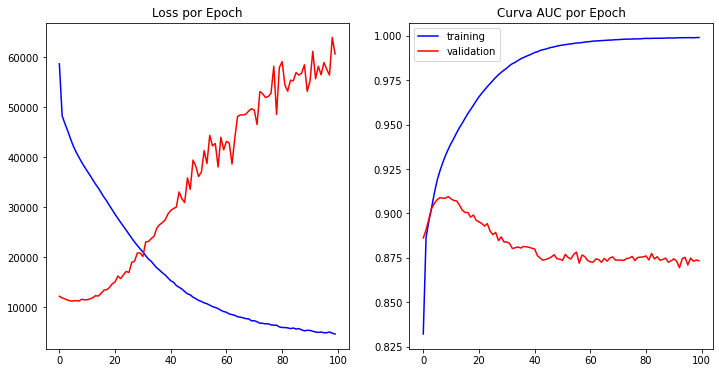

In [141]:
fig = plt.figure(figsize=(25, 6))

iax0 = fig.add_subplot(141)
iax0.set_title('Loss por Epoch')
x = range(0, len(loss_list))
iax0.plot(x, loss_list, label='training', c='blue')
iax0.plot(x, validation_loss_list, label='validation', c='red')

iax1 = fig.add_subplot(142)
iax1.set_title('Curva AUC por Epoch')
x = range(0, len(train_auc))
iax1.plot(x, train_auc, label='training', c='blue')
iax1.plot(x, validation_auc, label='validation', c='red')

plt.legend()

##### NNet con Embeddings y Dropout

In [50]:
device = ""
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"
device

'cuda:0'

In [27]:
class NNetWithEmbeddingsDropout(torch.nn.Module):

  def __init__(self, number_of_users, d1, number_of_products, d2):
    super().__init__()
    self.users_embedding = torch.nn.Embedding(num_embeddings=number_of_users, embedding_dim=d1)
    self.products_embedding = torch.nn.Embedding(num_embeddings=number_of_products, embedding_dim=d2)
    self.linear_1 = torch.nn.Linear(in_features=(21+d1+d2), out_features=100, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_3 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_3 = torch.nn.ReLU()
    self.linear_4 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_4 = torch.nn.ReLU()
    self.linear_5 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_5 = torch.nn.ReLU()
    self.linear_6 = torch.nn.Linear(in_features=100, out_features=100, bias=True)
    self.relu_6 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)

    self.dropout = torch.nn.Dropout(0.5)

  
  def forward(self, x, user_idx, product_idx):
    user_emb = self.users_embedding(user_idx)  # (64, d1)
    prod_emb = self.products_embedding(product_idx)  # (64, d2)

    final_input = torch.cat([x, user_emb, prod_emb], dim=1)  # (64, 21+d1+d2)

    x = self.linear_1(final_input) 
    x = self.relu_1(x) 
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.linear_3(x)
    x = self.relu_3(x)
    x = self.linear_4(x)
    x = self.relu_4(x)
    x = self.linear_5(x)
    x = self.relu_5(x)
    x = self.linear_6(x)
    x = self.relu_6(x)
    x = self.dropout(x)
    x = self.output(x)
    return x

In [28]:
nnet3 = NNetWithEmbeddingsDropout(number_of_users=len(users_idx), d1=8, number_of_products=len(products_idx), d2=8)
optimizer = torch.optim.Adam(nnet3.parameters(), lr=0.001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")
EPOCHS = 100
print(nnet3)

NNetWithEmbeddingsDropout(
  (users_embedding): Embedding(166821, 8)
  (products_embedding): Embedding(166821, 8)
  (linear_1): Linear(in_features=37, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=100, out_features=100, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=100, out_features=100, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=100, out_features=100, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=100, out_features=100, bias=True)
  (relu_6): ReLU()
  (output): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [29]:
nnet3.to(device)

loss_list = []
train_auc = []
validation_loss_list = []
validation_auc = []
for epoch in range(EPOCHS):

    running_loss = 0
    running_y_score = []
    running_y_label = []
    running_validation_loss = 0
    running_validation_y_score = []
    running_validation_y_label = []

    #### TRAINING ####
    for i, data in enumerate(train_dataloader):

        # datos del batch
        X_batch, user_idx_batch, product_idx_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        user_idx_batch = user_idx_batch.to(device)
        product_idx_batch = product_idx_batch.to(device)
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = nnet3(X_batch, user_idx_batch, product_idx_batch).reshape(-1)
        y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())  
        running_y_label += list(Y_batch.detach().cpu().numpy()) 

    # Metrics
    loss_list.append(running_loss)
    fpt, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
    auc = metrics.auc(fpt, tpr)
    train_auc.append(auc)
    print(f"Epoch {epoch} | Training loss: {running_loss} | AUC: {auc}")

    #### VALIDATION ####
    nnet3.eval()
    with torch.no_grad():

      for i, data in enumerate(valid_dataloader): 
        # Datos del batch
        X_validation_batch, user_idx_validation_batch, product_idx_validation_batch, y_validation_batch = data
        X_validation_batch = X_validation_batch.to(device).float()
        user_idx_validation_batch = user_idx_validation_batch.to(device)
        product_idx_validation_batch = product_idx_validation_batch.to(device)
        Y_validation_batch = y_validation_batch.to(device).float()

        # Forward
        y_validation_batch_score = nnet3(X_validation_batch, user_idx_validation_batch, product_idx_validation_batch).reshape(-1)
        y_validation_batch_hat = torch.sigmoid(y_validation_batch_score).reshape(-1)

        validation_loss = loss_function(y_validation_batch_score, Y_validation_batch) #  Calcula el loss

        # Acumular validation loss
        running_validation_loss += validation_loss.item()

        # Acumular metrics y_score and y
        running_validation_y_score += list(y_validation_batch_score.detach().cpu().numpy())
        running_validation_y_label += list(Y_validation_batch.detach().cpu().numpy())

      
      # Calcular las metricas (AUC)
      validation_loss_list.append(running_validation_loss)
      fpt_v, tpr_v, _ = metrics.roc_curve(running_validation_y_label, running_validation_y_score)
      auc_v = metrics.auc(fpt_v, tpr_v)
      validation_auc.append(auc_v)
      print(f"Epoch {epoch} | Validation loss: {running_validation_loss} | AUC: {auc_v}")

Epoch 0 | Training loss: 58286.9639339447 | AUC: 0.8387478542100434
Epoch 0 | Validation loss: 12614.114748954773 | AUC: 0.8801615278111055
Epoch 1 | Training loss: 47869.639488220215 | AUC: 0.8895364104105266
Epoch 1 | Validation loss: 12124.444098472595 | AUC: 0.8878110797543479
Epoch 2 | Training loss: 46325.78440666199 | AUC: 0.8975773638622812
Epoch 2 | Validation loss: 12039.063442707062 | AUC: 0.8911994973884301
Epoch 3 | Training loss: 45064.56762456894 | AUC: 0.9045366051331577
Epoch 3 | Validation loss: 12294.016028404236 | AUC: 0.8946878233944408
Epoch 4 | Training loss: 43638.67094922066 | AUC: 0.9118624497608594
Epoch 4 | Validation loss: 11644.876857757568 | AUC: 0.8995878005140112
Epoch 5 | Training loss: 42296.19253253937 | AUC: 0.9183862903854662
Epoch 5 | Validation loss: 11673.144097328186 | AUC: 0.9007092452525276
Epoch 6 | Training loss: 41190.7960062027 | AUC: 0.9233758088182973
Epoch 6 | Validation loss: 11523.610110282898 | AUC: 0.9013152323557112
Epoch 7 | Trai

##### Comparacion

Por un lado se implementó una red neuronal fully connected de 7 capas (6 con componente alineal y la última solo con la parte lineal) con cada capa intermedia con 100 neuronas y por otro lado se implementó una red neuronal de igual arquitectura pero agregando 2 embeddings, uno para los usuarios y otro para los productos.

Para la red neuronal que no tiene embeddings lo que se ve es que la red está haciendo underfitting, no llega a reducir el loss en el dataset de training ni en el de validation, por lo que quizás, con una arquitectura un poco más compleja se puedan llegar a obtener mejores resultados.

Para la red neuronal que tiene los 2 embeddings, lo que se ve es un claro overfitting. La red se aprende de memoria el dataset de training pero el error en validation crece a medida que pasan las epochs.


Nota:
Para este ejercicio se intentó trabajar el dataset inicial de distintas maneras, por ejemplo en lugar de remover las filas con null, remover las columnas Product_Category_2 y Product_Category_3 pero los resultados fueron similares o peores.

Por otro lado también se intentó trabajar con redes más pequeñas (2 o 3 capas) pero los efectos fueron similares.

#### Punto 4

Función

$y = a \log({b}) + b c^2$

Derivadas Analiticas

$\frac{\partial y}{\partial a} = log(b)$

$\frac{\partial y}{\partial b} = \frac{a}{b} + c^2$

$\frac{\partial y}{\partial c} = 2bc$

Derivadas usando Límite



Derivadas usando grafo de cómputo y regla de la cadena

Derivada respecto de a

$\frac{\partial y}{\partial a} = \lim\limits_{h \to 0}{\frac{(a+h)\log(b)+bc^2 -a\log(b) - bc^2}{h}}$ 

$= \lim\limits_{h \to 0}{\frac{(a+h)\log(b)+\cancel{bc^2} -a\log(b) - \cancel{bc^2}}{h}}$

$= \lim\limits_{h \to 0}{\frac{(a+h)\log(b) -a\log(b)}{h}}$

$= \lim\limits_{h \to 0}{\frac{(\cancel{a}+h\cancel{-a})\log(b)}{h}}$

$= \lim\limits_{h \to 0}{\frac{(h)\log(b)}{h}}$

$= \lim\limits_{h \to 0} { \log(b)}$

$= \log(b)$

Derivada respecto de b

$\frac{\partial y}{\partial b} = \lim\limits_{h \to 0}{\frac{(a)\log(b+h)+(b+h)c^2 -a\log(b) - bc^2}{h}} = \lim\limits_{h \to 0}{\frac{(a)\log(b+h)-a\log(b) + (b+h)c^2 - bc^2}{h}} $ 

$= \lim\limits_{h \to 0}{\frac{(a)\log(b+h)-a\log(b) + (\cancel{b}+ h \cancel{-b})c^2}{h}}$

$= \lim\limits_{h \to 0}{\frac{(a)\log(b+h)-a\log(b) + (h)c^2}{h}}$

$= \lim\limits_{h \to 0}{\frac{(a)\log(b+h)-a\log(b)}{h} + c^2}$

$= \lim\limits_{h \to 0}{\frac{a}{h} \log(\frac{b+h}{b}) + c^2}$

$= \lim\limits_{h \to 0}{\frac{a}{h} \log(1+\frac{h}{b}) + c^2}$

Planteo $h=vb$ entonces $v=\frac{h}{b}$. Se puede afirmar que cuando h tiende a 0 tambien lo hace v

$= \lim\limits_{v \to 0}{\frac{a}{vb} \log(1+v) + c^2}$

$= \lim\limits_{v \to 0}{\frac{a}{vb} \log(1+v) + c^2}$

$= \lim\limits_{v \to 0}{\frac{a}{b}\frac{\log(1+v)}{v} + c^2}$

Tenemos una indeterminacion del tipo $\frac{0}{0}$ por lo que tenemos que aplicar la regla de L'Hopital. Nos resulta:

$= \lim\limits_{v \to 0}{\frac{a}{b}\frac{\frac{1}{1+v}}{1} + c^2}$

$= \frac{a}{b} + c^2$

Derivada respecto de c

$\frac{\partial y}{\partial c} = \lim\limits_{h \to 0}{\frac{a\log(b)+b(c+h)^2 -a\log(b) - bc^2}{h}}$ 

$= \lim\limits_{h \to 0}{\frac{\cancel{a\log(b)}+b(c+h)^2 \cancel{-a\log(b)} - bc^2}{h}}$

$= \lim\limits_{h \to 0}{\frac{b(c+h)^2 - bc^2}{h}}$

$= \lim\limits_{h \to 0}{\frac{b(c^2 +2ch + h^2) - bc^2}{h}}$

$= \lim\limits_{h \to 0}{\frac{b(c^2 +2ch + h^2 - c^2)}{h}}$

$= \lim\limits_{h \to 0}{\frac{b(\cancel{c^2} +2ch + h^2 - \cancel{c^2})}{h}}$

$= \lim\limits_{h \to 0}{\frac{2bch}{h} \frac{bh^2}{h}}$

$= \lim\limits_{h \to 0}{\frac{2bc\cancel{h}}{\cancel{h}} \frac{\cancel{bh^2}}{\cancel{h}}}$

$= 2bc$

Derivada utilizando Grafo y Regla de la Cadena

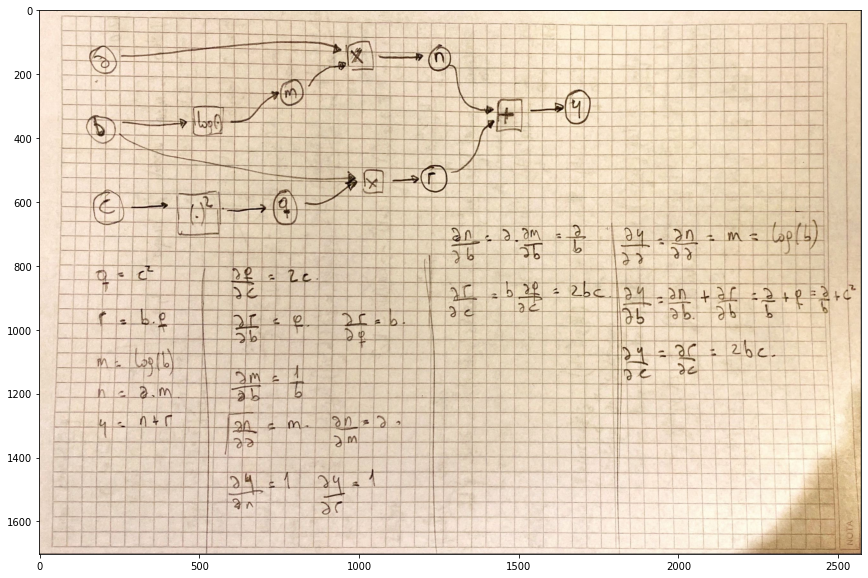

In [13]:
X = plt.imread('./IMG_5395.JPG')
plt.figure(figsize=(20,10))
plt.imshow(X)

Derivada utilizando Pytorch

In [9]:
a = torch.tensor(2., requires_grad=True)
b = torch.tensor(10., requires_grad=True)
c = torch.tensor(0.5, requires_grad=True)

y = ( a * torch.log(b) ) + ( b * torch.pow(c, 2) )

y.backward()

print("En a = 2 la derivada vale: ", a.grad)
print("En b = 10 la derivada vale: ", b.grad)
print("En c = 0.5 la derivada vale: ", c.grad)

En a = 2 la derivada vale:  tensor(2.3026)
En b = 10 la derivada vale:  tensor(0.4500)
En c = 0.5 la derivada vale:  tensor(10.)


Para todos los casos se verifica que:

- En $a=2$ la derivada es $log_{e}(10)$ que equivale a 2.3
- En $b=10$ la derivada es $\frac{2}{10} * 0.5^2$ que equivale a 0.45
- En $c=0.5$ la derivada es $2 * 10 * 0.5$ que equivale a 10